# Likelihood of Vector Orthogonality in High-Dimensional Spaces

>  Depends on whether you're using unit vectors or not.

- toc: true 
- badges: true
- comments: true
- author: Scott H. Hawley
- image: images/multidim_dp_summary.png

One sometimes sees the claims like ["within high dimensional spaces, if you choose random vectors, they tend to be orthogonal to each other"](https://towardsdatascience.com/loss-landscapes-and-the-blessing-of-dimensionality-46685e28e6a4), but is this true?

The answer **depends on whether you're talking about unit vectors or not**.  Let's do some direct computation. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)

n = 20000  # number of random pairs of vectors to try
dims = [2,3,5,10,50,1000]  # different dimensionalities to try
results = {}
test_num = 0

## Uniform distribution, Non-Normalized Vectors

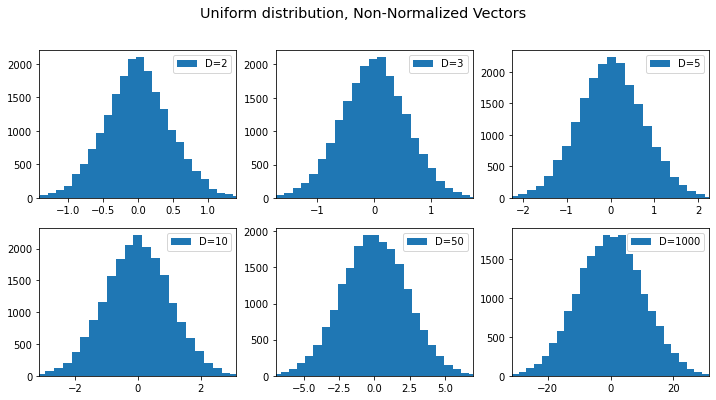

In [2]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Uniform distribution, Non-Normalized Vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")
a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = 2*np.random.rand(n,dim)-1
    b = 2*np.random.rand(n,dim)-1

    dots = (a*b).sum(axis=-1)

    ax.hist(dots, density=False, bins=30, label=f'D={dim}')  
    std = np.std(dots,axis=0)
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend()

From the above graph, we see that as the dimensionality D increases, it's still the case that the most common dot product is zero, but the probability distribution becomes wider & wider, i.e. the chances that a pair of random vectors are *not* orthogonal becomes increasingly *more* likely as D increases. 

## Uniform distribution, Unit vectors

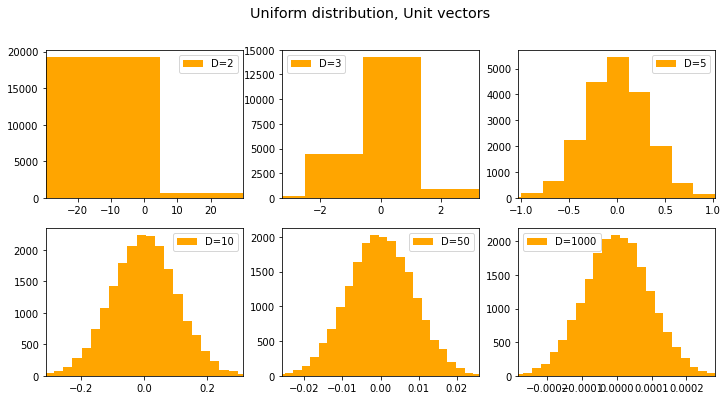

In [3]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Uniform distribution, Unit vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

def norm_rows(arr):
    mags = (arr*arr).sum(axis=-1)
    magstiled = np.tile(mags[:,np.newaxis],(1,arr.shape[-1]))
    return arr/magstiled

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = 2*np.random.rand(n,dim)-1
    b = 2*np.random.rand(n,dim)-1
    a, b = norm_rows(a), norm_rows(b)
    dots = (a*b).sum(axis=-1)
    ax.hist(dots, density=False, bins=30, label=f'D={dim}',color='orange')  # density=False would make counts)
    std = np.std(dots,axis=0)
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend()

In the above graphs we see the opposite: the distribution gets narrower as D increases, meaning that a given pair of random *unit* vectors are more likely to be orthogonal as D increases.

What if we draw from a normal distribution of components instead of a uniform one?

# Normal Distribution, Non-Normalized Vectors

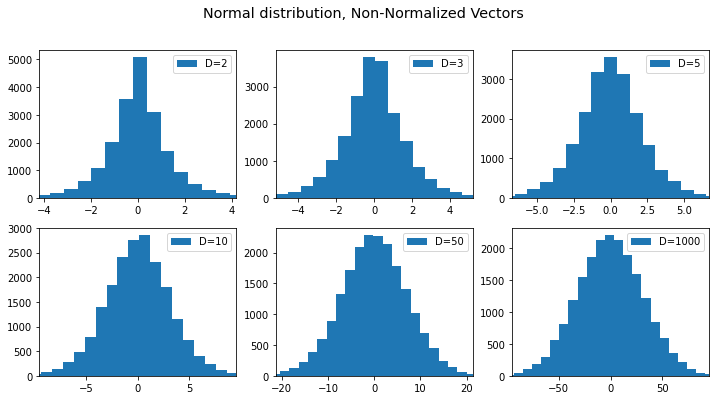

In [4]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Normal distribution, Non-Normalized Vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = np.random.normal(size=(n,dim))
    b = np.random.normal(size=(n,dim))
    dots = (a*b).sum(axis=-1)
    ax.hist(dots, density=False, bins=30, label=f'D={dim}')  
    std = np.std(dots,axis=0)
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend()

## Normal distribution, Unit Vectors 

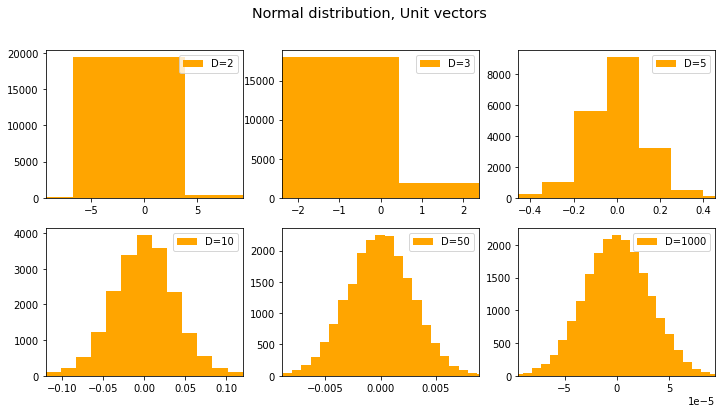

In [5]:
test_num += 1
fig, a = plt.subplots(2,3, figsize=(12,6))
results[test_num] = {'label':"Normal distribution, Unit vectors", 'sds':[]}
fig.suptitle(results[test_num]['label'], fontsize="x-large")

a = a.ravel()
for i,ax in enumerate(a):
    dim = dims[i]
    a = np.random.normal(size=(n,dim))
    b = np.random.normal(size=(n,dim))
    a, b = norm_rows(a), norm_rows(b)
    
    dots = (a*b).sum(axis=-1)
    ax.hist(dots, density=False, bins=30, label=f'D={dim}', color='orange')  # density=False would make counts
    std = np.std(dots,axis=0)
    results[test_num]['sds'].append(std)
    ax.set_xlim(-3*std,3*std)
    ax.legend()


looks like the normal distribution case is the same as the non-normalized vector case, only more extreme: the distribution gets narrower (around 0) as the dimension increases. 

**Note:** If the vectors have only positive components (e.g. what you get from softmax) then you will *never* have orthognogonal vectors (because they all exist in the "positive subspace").

## Summary 

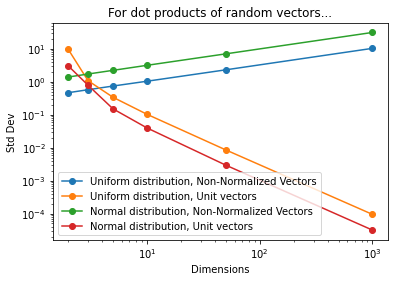

In [6]:
for key, val in enumerate(results):
    plt.loglog(dims, results[val]['sds'], 'o-', label=results[val]['label'])
plt.legend()
plt.xlabel('Dimensions')
plt.ylabel('Std Dev')
plt.title("For dot products of random vectors...")
plt.show()

Thus we see that unit the dot products of unit vectors are more likely to be zero as the dimensionality increases, whereas for other vectors it goes the other way. 